In [2]:
import os
import keras
import pandas as pd
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

shape of x:  (1, 224, 224, 3)
data type:  float32
predicted sunglass with probability 0.517
predicted sunglasses with probability 0.477
predicted brassiere with probability 0.001
predicted hook with probability 0.000
predicted loupe with probability 0.000
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_

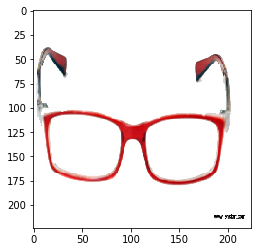

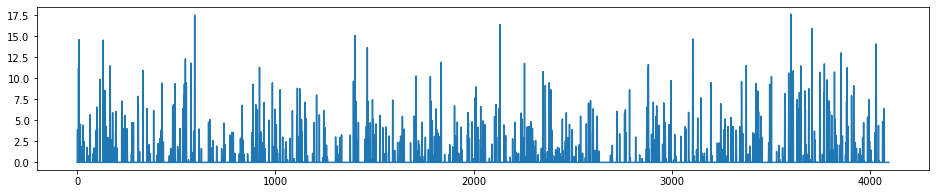

In [28]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

import numpy as np
import matplotlib.pyplot as plt

#Reshape of the image by (224,244)
def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:11])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

img, x = load_image("image3.jpg")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)


# forward the image through the network
predictions = model.predict(x)

# print out the 
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))
    

feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary() 

img, x = load_image("322868_1100-800x825.jpg")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,3))
plt.plot(feat[0])

#Image file insert
images_path = 'picture1'
image_extensions = ['.jpg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))
print(image)




In [21]:
!nvidia-smi

Tue Oct  5 12:45:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 462.31       Driver Version: 462.31       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P8    N/A /  N/A |     77MiB /  4096MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#Main Time Process
import time
tic = time.process_time()





features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.process_time()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.process_time()
    img, x = load_image(image_path)
    feat = feat_extractor.predict(x)[-1]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

analyzing image 0 / 5534. Time: 0.0000 seconds.
analyzing image 500 / 5534. Time: 560.6250 seconds.
analyzing image 1000 / 5534. Time: 577.1875 seconds.
analyzing image 1500 / 5534. Time: 601.2188 seconds.
analyzing image 2000 / 5534. Time: 581.4375 seconds.
analyzing image 2500 / 5534. Time: 573.2969 seconds.
analyzing image 3000 / 5534. Time: 592.0156 seconds.
analyzing image 3500 / 5534. Time: 580.0938 seconds.
analyzing image 4000 / 5534. Time: 587.0312 seconds.
analyzing image 4500 / 5534. Time: 588.5469 seconds.
analyzing image 5000 / 5534. Time: 595.4531 seconds.
analyzing image 5500 / 5534. Time: 590.6406 seconds.
finished extracting features for 5534 images


Text(0.5, 1.0, 'result images')

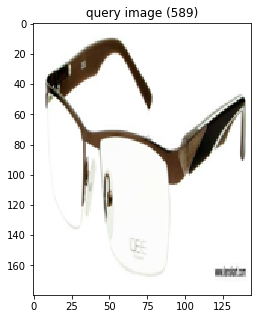

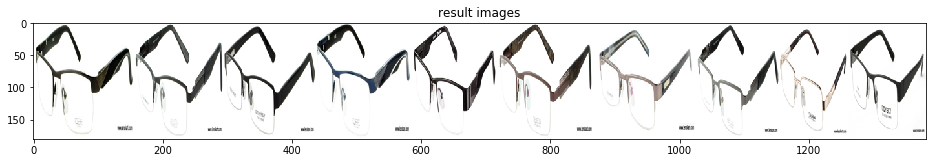

In [84]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)

pca_features = pca.transform(features)

import random

# grab a random query image
query_image_idx = int(len(images) * random.random())

# let's display the image
img = image.load_img(images[query_image_idx])
#plt.imshow(img)

from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:11]

def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:11]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * 50 / img.height), 180))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image
    
    
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)

query_image = get_concatenated_images([query_image_idx], 220)
results_image = get_concatenated_images(idx_closest, 220)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

Enter the name of the image file: image5.jpg


Text(0.5, 1.0, 'result images')

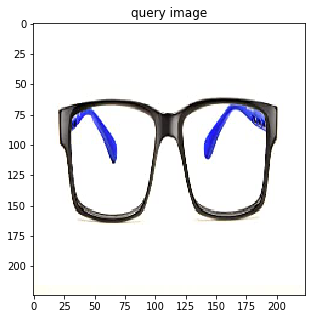

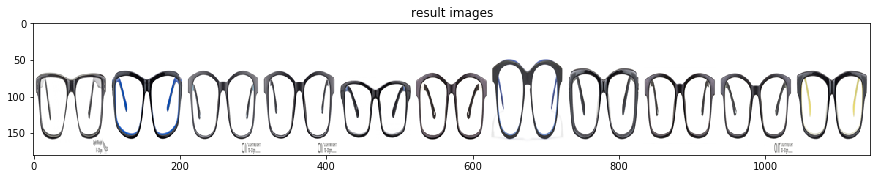

In [101]:
# load image and extract features
imageFileName = input("Enter the name of the image file: ")

new_image, x = load_image(imageFileName)
new_features = feat_extractor.predict(x)

# project it into pca space
new_pca_features = pca.transform(new_features)[0]

# calculate its distance to all the other images pca feature vectors
distances = [ distance.cosine(new_pca_features, feat) for feat in pca_features ]


idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[0:11]  # grab first 

results_image = get_concatenated_images(idx_closest,200)
    
# display the results
plt.figure(figsize = (5,5))
plt.imshow(new_image)
plt.title("query image")

# display the resulting images
plt.figure(figsize = (15,5))
plt.imshow(results_image)
plt.title("result images")

In [102]:
from PIL import Image 

# Python program to convert
# numpy array to image
  
# import required libraries
import numpy as np
from PIL import Image as im
  
data = im.fromarray(results_image)
data.save('results_image_2.jpg')